# Recommender Systems 2020/21

### Practice 3 - Content Based recommenders


### Load the data you saw last time:

In [1]:
from urllib.request import urlretrieve
import zipfile, os

# If file exists, skip the download
data_file_path = "data/Movielens_10M/"
data_file_name = data_file_path + "movielens_10m.zip"

# If directory does not exist, create
if not os.path.exists(data_file_path):
    os.makedirs(data_file_path)

if not os.path.exists(data_file_name):
    urlretrieve ("http://files.grouplens.org/datasets/movielens/ml-10m.zip", data_file_name)
    
dataFile = zipfile.ZipFile(data_file_name)
URM_path = dataFile.extract("ml-10M100K/ratings.dat", path="data/Movielens_10M")


In [2]:
import pandas as pd

URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep="::", 
                                header=None, 
                                dtype={0:int, 1:int, 2:float, 3:int})

URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction", "Timestamp"]

C:\Users\ferra\Anaconda3\envs\RecSysFramework\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [3]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction,Timestamp
0,1,122,5.0,838985046
1,1,185,5.0,838983525
2,1,231,5.0,838983392
3,1,292,5.0,838983421
4,1,316,5.0,838983392
5,1,329,5.0,838983392
6,1,355,5.0,838984474
7,1,356,5.0,838983653
8,1,362,5.0,838984885
9,1,364,5.0,838983707


## And now load the content informations in the same way:
## In this case we are using tags

In [4]:
ICM_path = dataFile.extract("ml-10M100K/tags.dat", path = "data/Movielens_10M")

ICM_dataframe = pd.read_csv(filepath_or_buffer=ICM_path, 
                            sep="::", 
                            header=None, 
                            dtype={0:int, 1:int, 2:str, 3:int})

ICM_dataframe.columns = ["UserID", "ItemID", "FeatureID", "Timestamp"]

C:\Users\ferra\Anaconda3\envs\RecSysFramework\lib\site-packages\ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [5]:
ICM_dataframe.head(n=10)

,UserID,ItemID,FeatureID,Timestamp
0,15,4973,excellent!,1215184630
1,20,1747,politics,1188263867
2,20,1747,satire,1188263867
3,20,2424,chick flick 212,1188263835
4,20,2424,hanks,1188263835
5,20,2424,ryan,1188263835
6,20,2947,action,1188263755
7,20,2947,bond,1188263756
8,20,3033,spoof,1188263880
9,20,3033,star wars,1188263880


### We can see that most users and items have no data associated to them

In [6]:
n_features = len(ICM_dataframe["FeatureID"].unique())

print ("Number of tags\t {}, Number of item-tag tuples {}".format(n_features, len(ICM_dataframe)))


Number of tags	 16529, Number of item-tag tuples 95580


## We now build the sparse URM and ICM matrices

### The tags are strings, we should traslate them into numbers so we can use them as indices in the ICM. We should also ensure that the item indices we use in ICM and URM are consistent.

In [7]:
user_original_ID_to_index_dict = {}

for user_id in URM_all_dataframe["UserID"].unique():
    user_original_ID_to_index_dict[user_id] = len(user_original_ID_to_index_dict)    

In [8]:
item_original_ID_to_index_dict = {}

for item_id in URM_all_dataframe["ItemID"].unique():
    item_original_ID_to_index_dict[item_id] = len(item_original_ID_to_index_dict)
    
for item_id in ICM_dataframe["ItemID"].unique():
    if item_id not in item_original_ID_to_index_dict:
        item_original_ID_to_index_dict[item_id] = len(item_original_ID_to_index_dict)

In [9]:
feature_original_ID_to_index_dict = {}

for feature_id in ICM_dataframe["FeatureID"].unique():
    feature_original_ID_to_index_dict[feature_id] = len(feature_original_ID_to_index_dict)

In [10]:
original_feature_ID = "star wars"
print("New index for feature '{}' is {}".format(original_feature_ID, feature_original_ID_to_index_dict[original_feature_ID]))

New index for feature 'star wars' is 9


# We can now build the URM and ICM using the new indices


In [11]:
URM_all_dataframe["UserID"] = [user_original_ID_to_index_dict[user_original] for user_original in
                                      URM_all_dataframe["UserID"].values]

URM_all_dataframe["ItemID"] = [item_original_ID_to_index_dict[item_original] for item_original in 
                                      URM_all_dataframe["ItemID"].values]

ICM_dataframe["ItemID"] = [item_original_ID_to_index_dict[item_original] for item_original in 
                                      ICM_dataframe["ItemID"].values]

ICM_dataframe["FeatureID"] = [feature_original_ID_to_index_dict[feature_original] for feature_original in 
                                      ICM_dataframe["FeatureID"].values]

In [12]:
URM_all_dataframe.head(n=10)

,UserID,ItemID,Interaction,Timestamp
0,0,0,5.0,838985046
1,0,1,5.0,838983525
2,0,2,5.0,838983392
3,0,3,5.0,838983421
4,0,4,5.0,838983392
5,0,5,5.0,838983392
6,0,6,5.0,838984474
7,0,7,5.0,838983653
8,0,8,5.0,838984885
9,0,9,5.0,838983707


In [13]:
ICM_dataframe.head(n=10)

,UserID,ItemID,FeatureID,Timestamp
0,15,1926,0,1215184630
1,20,1040,1,1188263867
2,20,1040,2,1188263867
3,20,1086,3,1188263835
4,20,1086,4,1188263835
5,20,1086,5,1188263835
6,20,612,6,1188263755
7,20,612,7,1188263756
8,20,628,8,1188263880
9,20,628,9,1188263880


### When we create the matrices we need to make sure they have the same shape (items may be missing in one if they have no tags or no interactions

In [14]:
import scipy.sparse as sps
import numpy as np

n_users = len(user_original_ID_to_index_dict)
n_items = len(item_original_ID_to_index_dict)
n_features = len(feature_original_ID_to_index_dict)

In [15]:
URM_all = sps.csr_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)),
                        shape = (n_users, n_items))

URM_all

<69878x10681 sparse matrix of type '<class 'numpy.float64'>'
	with 10000054 stored elements in Compressed Sparse Row format>

In [16]:
ICM_all = sps.csr_matrix((np.ones(len(ICM_dataframe["ItemID"].values)), 
                          (ICM_dataframe["ItemID"].values, ICM_dataframe["FeatureID"].values)),
                        shape = (n_items, n_features))

ICM_all.data = np.ones_like(ICM_all.data)

ICM_all

<10681x16529 sparse matrix of type '<class 'numpy.float64'>'
	with 71155 stored elements in Compressed Sparse Row format>

# Let's take a look at the ICM

### We leverage CSR and CSC indptr data structure to compute the number of cells that have values for that row or column

In [17]:
ICM_all = sps.csr_matrix(ICM_all)
features_per_item = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csc_matrix(ICM_all)
items_per_feature = np.ediff1d(ICM_all.indptr)

ICM_all = sps.csr_matrix(ICM_all)

In [18]:
print(features_per_item.shape)
print(items_per_feature.shape)

(10681,)
(16529,)


In [19]:
features_per_item = np.sort(features_per_item)
items_per_feature = np.sort(items_per_feature)

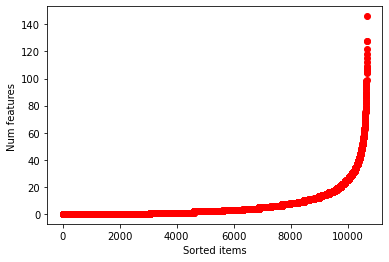

In [20]:
import matplotlib.pyplot as pyplot
%matplotlib inline  

pyplot.plot(features_per_item, 'ro')
pyplot.ylabel('Num features ')
pyplot.xlabel('Sorted items')
pyplot.show()

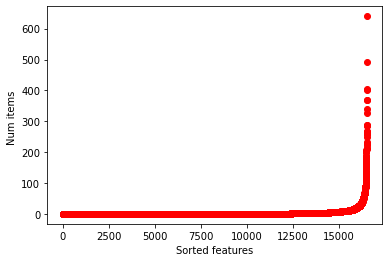

In [21]:
pyplot.plot(items_per_feature, 'ro')
pyplot.ylabel('Num items ')
pyplot.xlabel('Sorted features')
pyplot.show()

# We can now build the recommender algorithm, but first we need the train/test split and the evaluation function:

In [22]:
from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.80)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])


In [23]:
from Base.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

class ItemKNNCBFRecommender(object):
    
    def __init__(self, URM, ICM):
        self.URM = URM
        self.ICM = ICM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.ICM.T, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

### We need to define Cosine similarity... Let's look at the attached source code

### See also a [list of commonly used KNN similarity heuristics](https://github.com/MaurizioFD/RecSys_Course_2018/blob/master/slides/List_of_KNN_similarity_heuristics.pdf)

## A KNN is built with the following steps:
* Compute the similarity of an item with all others
* Select the k-highest similarities

In [24]:
item_id = 80
shrink = 10

The numerator is the dot product of the item features times the whole ICM data transposed

In [25]:
numerator_vector = ICM_all[item_id].dot(ICM_all.T).toarray().ravel()
numerator_vector

array([2., 0., 0., ..., 0., 1., 0.])

In [26]:
item_norms = np.sqrt(np.array(ICM_all.T.power(2).sum(axis=0))).ravel()
item_norms

array([1.73205081, 4.35889894, 5.29150262, ..., 1.        , 1.41421356,
       1.41421356])

The denominator will be the product of norms plus the srink term and a small value which prevents the denominator to be zero (only for non-negative data)

In [27]:
denominator_vector = item_norms[item_id] * item_norms + shrink + 1e-6
denominator_vector

array([15.47722658, 23.78404975, 26.73320153, ..., 13.16227866,
       14.47213695, 14.47213695])

In [28]:
similarity_vector = numerator_vector/denominator_vector

Let's sort the similarity from the highest to the lowest

In [29]:
sorted_item_indices = np.argsort(-similarity_vector)
sorted_item_indices

array([   80,  3542,     0, ...,  3938,  3931, 10680], dtype=int64)

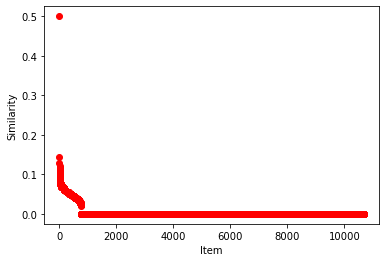

In [30]:
pyplot.plot(similarity_vector[sorted_item_indices], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

Now we select the k most similar items

In [31]:
k = 100

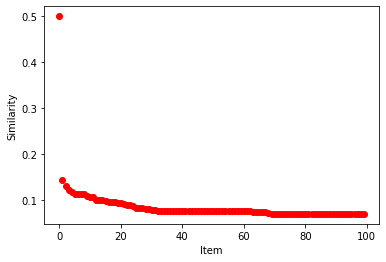

In [32]:
pyplot.plot(similarity_vector[sorted_item_indices[0:k]], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

The operation is performed for all items.
A simple strategy to perform it efficiently is to vectorize the most computationally intensive part, the dot product, on a group of items. The speedup can be of a factor of 10-100.
This strategy is limited by the fact that the result of the dot product is a huge item-item dense similarity which likely does not fit in memory.

In [33]:
import traceback

try:
    numerator_matrix = ICM_all.dot(ICM_all.T).toarray()
    
except Exception as e:
    traceback.print_exc()
    

The solution is:
* Compute the numerator a block of items at a time leveraging vectorization while not running out of memory
* Extract the k-nn on those items
* Built incrementally the sparse similarity matrix

In [34]:
block_size = 100

numerator_block = ICM_all[0:block_size].dot(ICM_all.T).toarray()
numerator_block.shape

(100, 10681)

Let's compare the speed to compute the dot product on the whole similarity of the two strategies

In [35]:
import time

n_items = ICM_all.shape[0]

start_time = time.time()

for n_item in range(n_items):
    numerator_vector = ICM_all[item_id].dot(ICM_all.T).toarray().ravel()
    
end_time = time.time()

print("Computing the similarity one item at a time runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))



Computing the similarity one item at a time runs at 952.02 items/sec


In [36]:
n_items = ICM_all.shape[0]

start_time = time.time()

block_size = 100
blocks_start_positions = range(0, n_items, block_size)

for start_pos in blocks_start_positions:
    end_pos = min(start_pos + block_size, n_items)
    
    numerator_block = ICM_all[start_pos:end_pos].dot(ICM_all.T).toarray()
    
end_time = time.time()

print("Computing the similarity in blocks of 100 items at a time runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))



Computing the similarity in blocks of 100 items at a time runs at 24406.78 items/sec


### In this case the vectorized implementation runs >50 times faster!

#### Usually most of the speed gain comes with blocks of 100 or so items, depending on the system. Much higher than that tends to not be beneficial while requiring increasingly more memory.

Now an example of something you should *never* do, nested loops to compute the similarity of each item without vectorization

In [37]:
n_items = 100

start_time = time.time()

for n_item in range(n_items):
    for second_item in range(n_items):
        numerator_vector = ICM_all[item_id].dot(ICM_all[second_item].T)
    
end_time = time.time()

print("Computing the similarity with nested loops runs at {:.2f} items/sec".format(n_items/(end_time-start_time)))



Computing the similarity with nested loops runs at 28.59 items/sec


You see how incredibly slow nested loops are compared to a well vectorized implementation

## Test our CBF recommender:

In [38]:
recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 10681 ( 100 % ), 3841.47 column/sec, elapsed time 0.05 min


In [39]:
for user_id in range(10):
    print(recommender.recommend(user_id, at=5))

[1427   94 1451 7310 1331]
[192   7  37 402 133]
[ 798   60 5660 5664  133]
[8913   94   28  554 1427]
[ 176    7  402 1293 1008]
[ 37  19  14 798  31]
[220 218  44 219 164]
[1609 2952 2093 2065 4618]
[ 585 4584 1994 2400  586]
[7118 6578 6791    7 1314]


#### Let's talk about speed

#### Time to compute recommendations for a fixed group of users

In [40]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)
    
end_time = time.time()

print("Reasonable implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))


Reasonable implementation speed is 651.08 usr/sec


### Let's add a common mistake.... a CSC URM

In [41]:
URM_train_csc = URM_train.tocsc()

recommender = ItemKNNCBFRecommender(URM_train_csc, ICM_all)
recommender.fit(shrink=0.0, topK=50)

Similarity column 10681 ( 100 % ), 3951.95 column/sec, elapsed time 0.05 min


In [42]:
import time, traceback

try:

    n_users_to_test = 1000

    start_time = time.time()

    for user_id in range(n_users_to_test):
        recommender.recommend(user_id, at=5)

    end_time = time.time()

    print("Wrong implementation speed is {:.2f} usr/sec".format(n_users_to_test/(end_time-start_time)))

    
except Exception as e:
        
    print("Exception {}".format(str(e)))
    traceback.print_exc()


Exception index 10683 is out of bounds for axis 0 with size 10681


Traceback (most recent call last):
  File "<ipython-input-42-cd8883de5544>", line 10, in <module>
    recommender.recommend(user_id, at=5)
  File "<ipython-input-23-88972fee293e>", line 25, in recommend
    scores = self.filter_seen(user_id, scores)
  File "<ipython-input-23-88972fee293e>", line 40, in filter_seen
    scores[user_profile] = -np.inf
IndexError: index 10683 is out of bounds for axis 0 with size 10681


## Parameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Number of neighbors

In [43]:
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_k.append(result_dict[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 76 (0.71 %) cold items.
Similarity column 10681 ( 100 % ), 13707.60 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 68000 ( 97.42% ) in 30.32 sec. Users per second: 2243
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 31.09 sec. Users per second: 2245
ItemKNNCBFRecommender: URM Detected 76 (0.71 %) cold items.
Similarity column 10681 ( 100 % ), 13984.33 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 62000 ( 88.82% ) in 30.08 sec. Users per second: 2061
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 33.79 sec. Users per second: 2066
ItemKNNCBFRecommender: URM Detected 76 (0.71 %) cold items.
Similarity column 10681 ( 100 % ), 13751.09 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 57000 ( 81.66% ) in 30.26 sec. Users per second: 1884
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 36.87 sec. Users per second: 1893
ItemKNNCBFRecommender: URM Detected 76 (0.71 %) cold items.
Similarity column 10681 ( 100 %

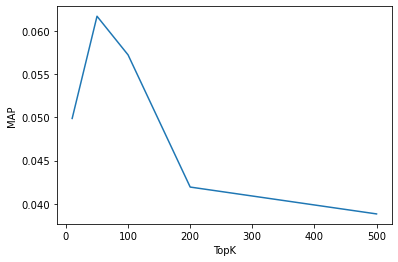

In [44]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

#### On this dataset the number of neighbors does not have a great impact on MAP. Higher values of TopK might work even better

#### Different datasets will behave in different ways.

### Shrinkage

In [45]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:
    
    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(shrink=shrink, topK=100)
    
    result_dict, _ = evaluator_test.evaluateRecommender(recommender)
    
    MAP_per_shrinkage.append(result_dict[10]["MAP"])

ItemKNNCBFRecommender: URM Detected 76 (0.71 %) cold items.
Similarity column 10681 ( 100 % ), 13448.96 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 57000 ( 81.66% ) in 30.39 sec. Users per second: 1876
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 36.99 sec. Users per second: 1887
ItemKNNCBFRecommender: URM Detected 76 (0.71 %) cold items.
Similarity column 10681 ( 100 % ), 13333.75 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 54000 ( 77.36% ) in 30.44 sec. Users per second: 1774
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 39.38 sec. Users per second: 1773
ItemKNNCBFRecommender: URM Detected 76 (0.71 %) cold items.
Similarity column 10681 ( 100 % ), 13223.50 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 51000 ( 73.06% ) in 30.33 sec. Users per second: 1682
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 41.85 sec. Users per second: 1668
ItemKNNCBFRecommender: URM Detected 76 (0.71 %) cold items.
Similarity column 10681 ( 100 %

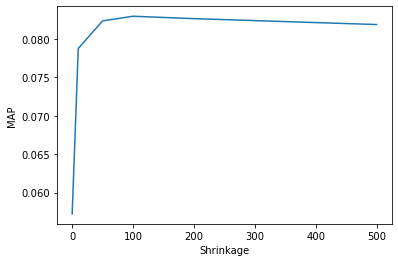

In [46]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()

#### The shrinkage value (i.e. support) have a much stronger impact. Combine a parameter search with the two to ensure maximum recommendation quality

## Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# Feature weighting

# IDF

![title](https://www.link-assistant.com/images/news/tf-idf-tool-for-seo/screen-03.png)

In [47]:
num_tot_items = ICM_all.shape[0]

# let's count how many items have a certain feature
items_per_feature = np.ediff1d(ICM_all.indptr)

IDF = np.array(np.log(num_tot_items / items_per_feature))

print(ICM_all.shape)
print(IDF.shape)

(10681, 16529)
(10681,)


C:\Users\ferra\Anaconda3\envs\RecSysFramework\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [48]:
IDF

array([8.17760945, 6.33178276, 5.94401723, ..., 9.27622174, 8.58307456,
       8.58307456])

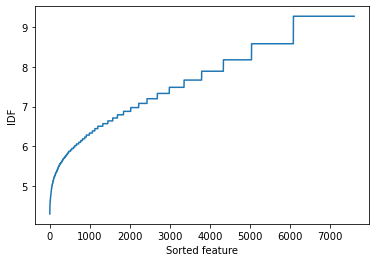

In [49]:
pyplot.plot(np.sort(IDF))
pyplot.ylabel('IDF')
pyplot.xlabel('Sorted feature')
pyplot.show()

#### Highest ranked features

In [50]:
feature_index_to_original_ID_dict = {value:key for key,value in feature_original_ID_to_index_dict.items()}

In [51]:
sorted_features = np.argsort(-IDF)

highest_ranked_features = sorted_features[:20]

for feature_index in highest_ranked_features:
    print(feature_index_to_original_ID_dict[feature_index])

Dance
Nicholas Meyer
John Woo
solidarity
author:Laurence Stern
utah
transexual
Barry Sonnenfeld
Peter Cattaneo
Bonneville Salt Flats
legal system
Juliette Binoche and Daniel Auteuil also together in Hidden (a.k.a. Cache) (2005)
score:George Fenton
tear jerker
R:brief language
RRobert Carlyle
great war depiction
champagne
based upon a true story
colonial power


#### Lowest ranked features

In [52]:
lowest_ranked_features = sorted_features[-20:]

for feature_index in lowest_ranked_features:
    print(feature_index_to_original_ID_dict[feature_index])    

rats
melancholy
comic book
jfd
willem defoe
inspirational
crapflix
sweet story
Seen 2008
Nostalgic
Michael Crichton
bond
gratuitous sex
los angeles
biography
Fate
goth
moon
Shakespeare
creepy


In [53]:
from scipy.sparse import diags
diags(IDF)

<10681x10681 sparse matrix of type '<class 'numpy.float64'>'
	with 10681 stored elements (1 diagonals) in DIAgonal format>

In [54]:
ICM_idf = ICM_all.copy()

ICM_idf = diags(IDF)*ICM_idf

In [55]:
recommender_idf = ItemKNNCBFRecommender(URM_train, ICM_idf)
recommender_idf.fit(shrink=0.0, topK=50)

result_dict, _ = evaluator_test.evaluateRecommender(recommender_idf)
result_dict[10]

ItemKNNCBFRecommender: URM Detected 76 (0.71 %) cold items.
Similarity column 10681 ( 100 % ), 13866.17 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 60000 ( 85.95% ) in 30.08 sec. Users per second: 1995
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 34.92 sec. Users per second: 1999


{'ROC_AUC': 0.29817508695549105,
 'PRECISION': 0.10901667526218102,
 'PRECISION_RECALL_MIN_DEN': 0.11670332827610287,
 'RECALL': 0.05035349452829048,
 'MAP': 0.061672478062843636,
 'MRR': 0.2648113811643271,
 'NDCG': 0.07469623453893716,
 'F1': 0.06888830662003666,
 'HIT_RATE': 1.0901667526216263,
 'ARHR': 0.38480877409125747,
 'NOVELTY': 0.011183876319818596,
 'AVERAGE_POPULARITY': 0.2782547336749187,
 'DIVERSITY_MEAN_INTER_LIST': 0.9504444680724227,
 'DIVERSITY_HERFINDAHL': 0.995043085216978,
 'COVERAGE_ITEM': 0.461005523827357,
 'COVERAGE_ITEM_CORRECT': 0.10298661174047374,
 'COVERAGE_USER': 0.9989410114771459,
 'COVERAGE_USER_CORRECT': 0.5010732991785684,
 'DIVERSITY_GINI': 0.05304217256200315,
 'SHANNON_ENTROPY': 9.078632185900538}

#### There is  a small gain over the non-weighted ICM. Try other feature weighting methods like BM25...

# BM25

In [56]:
from Base.IR_feature_weighting import okapi_BM_25

ICM_BM25 = ICM_all.copy().astype(np.float32)
ICM_BM25 = okapi_BM_25(ICM_BM25)
ICM_BM25 = ICM_BM25.tocsr()

In [57]:
recommender_bm25 = ItemKNNCBFRecommender(URM_train, ICM_BM25)
recommender_bm25.fit(shrink=0.0, topK=50)

result_dict, _ = evaluator_test.evaluateRecommender(recommender_bm25)
result_dict[10]

ItemKNNCBFRecommender: URM Detected 76 (0.71 %) cold items.
Similarity column 10681 ( 100 % ), 13665.11 column/sec, elapsed time 0.01 min
EvaluatorHoldout: Processed 59000 ( 84.52% ) in 30.28 sec. Users per second: 1949
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 35.63 sec. Users per second: 1959


{'ROC_AUC': 0.228198092413854,
 'PRECISION': 0.06890865852959276,
 'PRECISION_RECALL_MIN_DEN': 0.0741563736739515,
 'RECALL': 0.033346811667434355,
 'MAP': 0.03788837295384486,
 'MRR': 0.19065681527325357,
 'NDCG': 0.04915503473516965,
 'F1': 0.04494398302241009,
 'HIT_RATE': 0.6890865852959716,
 'ARHR': 0.25674773720159,
 'NOVELTY': 0.012740733837520155,
 'AVERAGE_POPULARITY': 0.15750530068451868,
 'DIVERSITY_MEAN_INTER_LIST': 0.9732223175296154,
 'DIVERSITY_HERFINDAHL': 0.9973208375315451,
 'COVERAGE_ITEM': 0.49695721374403146,
 'COVERAGE_ITEM_CORRECT': 0.12049433573635428,
 'COVERAGE_USER': 0.9989410114771459,
 'COVERAGE_USER_CORRECT': 0.3754257420074988,
 'DIVERSITY_GINI': 0.08389737232099666,
 'SHANNON_ENTROPY': 9.928055940666297}

#### Another small gain over TF-IDF

# Unnormalized similarity matrix

In [58]:
recommender_dot = ItemKNNCBFRecommender(URM_train, ICM_all)
recommender_dot.W_sparse = ICM_all * ICM_all.T

result_dict, _ = evaluator_test.evaluateRecommender(recommender_dot)
result_dict[10]

ItemKNNCBFRecommender: URM Detected 76 (0.71 %) cold items.
EvaluatorHoldout: Processed 34000 ( 48.71% ) in 30.56 sec. Users per second: 1113
EvaluatorHoldout: Processed 68000 ( 97.42% ) in 1.02 min. Users per second: 1114
EvaluatorHoldout: Processed 69804 ( 100.00% ) in 1.04 min. Users per second: 1114


{'ROC_AUC': 0.3636344633454427,
 'PRECISION': 0.1242278379462808,
 'PRECISION_RECALL_MIN_DEN': 0.1348390516121123,
 'RECALL': 0.06030165032252184,
 'MAP': 0.0733453690421935,
 'MRR': 0.32609542546796105,
 'NDCG': 0.09524330620838328,
 'F1': 0.08119183242135528,
 'HIT_RATE': 1.242278379462495,
 'ARHR': 0.4618260323918133,
 'NOVELTY': 0.008518464910100908,
 'AVERAGE_POPULARITY': 0.5844368865768736,
 'DIVERSITY_MEAN_INTER_LIST': 0.5998851255180685,
 'DIVERSITY_HERFINDAHL': 0.959987653166778,
 'COVERAGE_ITEM': 0.04437786724089505,
 'COVERAGE_ITEM_CORRECT': 0.017601348188371876,
 'COVERAGE_USER': 0.9989410114771459,
 'COVERAGE_USER_CORRECT': 0.585162712155471,
 'DIVERSITY_GINI': 0.002438424668269807,
 'SHANNON_ENTROPY': 5.048665358967519}